## Introduction
Recommendations are being used to recommend everything from movies to music to friends to new destinations. There are three main methods for implementing recommendations that you will become familiar with throughout this lesson:

- Knowledge Based Recommendations
- Collaborative Filtering Based Recommendations
- Content Based Recommendations

Within Collaborative Filtering, there are two main branches:

- Model Based Collaborative Filtering
- Neighborhood Based Collaborative Filtering

## Similarity Metrics
In order to implement Neighborhood Based Collaborative Filtering, you will learn about some common ways to measure the similarity between two users (or two items) including:

1. Pearson's correlation coefficient
2. Spearman's correlation coefficient
3. Kendall's Tau
4. Euclidean Distance
5. Manhattan Distance

You will learn why sometimes one metric works better than another by looking at a specific situation where one metric provides more information than another.

## Business Cases For Recommendations
Finally, you will look at the four ideas needed for businesses to implement successful recommendations to drive revenue, which include:

1. Relevance
2. Novelty
3. Serendipity
4. Increased Diversity


### Recommendations with MovieTweetings: Getting to Know The Data

Throughout this lesson, you will be working with the [MovieTweetings Data](https://github.com/sidooms/MovieTweetings/tree/master/recsyschallenge2014).  To get started, you can read more about this project and the dataset from the [publication here](http://crowdrec2013.noahlab.com.hk/papers/crowdrec2013_Dooms.pdf).

**Note:** There are solutions to each of the notebooks available by hitting the orange jupyter logo in the top left of this notebook.  Additionally, you can watch me work through the solutions on the screencasts that follow each workbook. 

To get started, read in the libraries and the two datasets you will be using throughout the lesson using the code below.


In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tests as t

%matplotlib inline

# Read in the datasets
movies = pd.read_csv('https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/movies.dat', delimiter='::', header=None, names=['movie_id', 'movie', 'genre'], dtype={'movie_id': object}, engine='python')
reviews = pd.read_csv('https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/ratings.dat', delimiter='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], dtype={'movie_id': object, 'user_id': object, 'timestamp': object}, engine='python')


#### 1. Take a Look At The Data 

Take a look at the data and use your findings to fill in the dictionary below with the correct responses to show your understanding of the data.

In [118]:
movies.head()

,movie_id,movie,genre
0,0000008,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short
1,0000010,La sortie des usines Lumière (1895),Documentary|Short
2,0000012,The Arrival of a Train (1896),Documentary|Short
3,25,The Oxford and Cambridge University Boat Race ...,NaN
4,0000091,Le manoir du diable (1896),Short|Horror


In [119]:
reviews.head()

,user_id,movie_id,rating,timestamp
0,1,0114508,8,1381006850
1,2,0358273,9,1579057827
2,2,10039344,5,1578603053
3,2,6751668,9,1578955697
4,2,7131622,8,1579559244


In [120]:
print(movies.movie_id.count())
print(reviews.rating.value_counts().index)


35268
Int64Index([8, 7, 9, 6, 10, 5, 4, 3, 1, 2, 0], dtype='int64')


In [121]:
genre = []
for i in range(movies.shape[0]):
    try:
        genre.extend(movies['genre'].loc[i].split('|'))
    except AttributeError:
        pass

genre_set = set(genre)
len(genre_set)

28

In [122]:
len(reviews.user_id.unique())

66759

In [123]:
reviews.rating.isnull().sum()

0

In [124]:
reviews['rating'].describe()

count    857106.000000
mean          7.315439
std           1.854066
min           0.000000
25%           6.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: rating, dtype: float64

In [125]:
# Use your findings to match each variable to the correct statement in the dictionary


dict_sol1 = {
'The number of movies in the dataset': 35263,
'The number of ratings in the dataset': 11,
'The number of different genres': 28,
'The number of unique users in the dataset': 66722,
'The number missing ratings in the reviews dataset':0,
'The average rating given across all ratings': 7,
'The minimum rating given across all ratings': 0,
'The maximum rating given across all ratings': 10
}

# Originally, I had this to check your solution, but the 
# links are live and updating.  That didn't end up being
# a great idea


#### 2. Data Cleaning

Next, we need to pull some additional relevant information out of the existing columns. 

For each of the datasets, there are a couple of cleaning steps we need to take care of:

#### Movies
* Pull the date from the title and create new column
* Dummy the date column with 1's and 0's for each century of a movie (1800's, 1900's, and 2000's)
* Dummy column the genre with 1's and 0's

#### Reviews
* Create a date out of time stamp

You can check your results against the header of my solution by running the cell below with the **show_clean_dataframes** function.

In [126]:
# Pull the date from the title and create new column
def year(movie):
    try:
        return(movie.split('(')[1][:4])
    except:
        return np.nan

movies['date'] = movies.movie.apply(year).astype(int)


In [127]:
# Dummy the date column with 1's and 0's for each century of a movie (1800's, 1900's, 
# and 2000's)

def year_00s(year):
    if 1800 <= year < 1900:
        return "1800's"
    elif 1900 <= year < 2000:
        return "1900's"
    elif year >= 1900:
        return "2000's"
    
centry = movies['date'].apply(year_00s)
movies = pd.concat([movies, pd.get_dummies(centry)],axis = 1)



In [128]:
# Dummy column the genre with 1's and 0's
# Function to split and return values for columns
def split_genres(val):
    try:
        if val.find(gene) >-1: # if not find, return -1, or the position of the string
            return 1
        else:
            return 0
    except AttributeError:
        return 0

# Apply function for each genre
for gene in list(genre_set):        
    movies[gene] = movies['genre'].apply(split_genres)

#### My original method

```python
# Dummy column the genre with 1's and 0's
def get_genre_list(genre):
    return genre.split('|')

zero_df = pd.DataFrame(0, index=np.arange(movies.shape[0]), columns=list(genre_set))
movies = pd.concat([movies,zero_df],axis = 1)

for i in range(movies.shape[0]):
    if pd.notnull(movies.loc[i,'genre']):
        _list = movies['genre'].loc[i].split('|')
        for gen in _list:
            movies.loc[i,gen] = '1'
```


In [129]:
movies.head()

,movie_id,movie,genre,date,1800's,1900's,2000's,Adult,Short,Crime,...,Horror,Western,Comedy,Musical,Animation,Biography,News,Sci-Fi,Fantasy,Adventure
0,0000008,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short,1894,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0000010,La sortie des usines Lumière (1895),Documentary|Short,1895,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0000012,The Arrival of a Train (1896),Documentary|Short,1896,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,25,The Oxford and Cambridge University Boat Race ...,NaN,1895,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0000091,Le manoir du diable (1896),Short|Horror,1896,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [130]:
# Create a date out of time stamp

import datetime
change_timestamp = lambda val: datetime.datetime.fromtimestamp(int(val)).strftime('%Y-%m-%d %H:%M:%S')
# .strftime("%Y-%m-%d %H:%M:%S") convert timestamp to year-month-day-hour-min-sec
reviews['date'] = reviews['timestamp'].apply(change_timestamp)

In [131]:
# now reviews and movies are the final dataframes with the necessary columns
reviews.to_csv('reviews_clean.csv',index = False)
movies.to_csv('movies_clean.csv',index = False)

## Knowledge Based Recommendations
A knowledge based recommendation is one in which knowledge about the item or user preferences are used to make a recommendation.

Knowledge based recommendations are pretty common when purchasing luxury items. Take a look at the filters available on Zillow in the image below. This is an example of building in a knowledge based recommendation, as users can add their own preferences to the items that are provided.
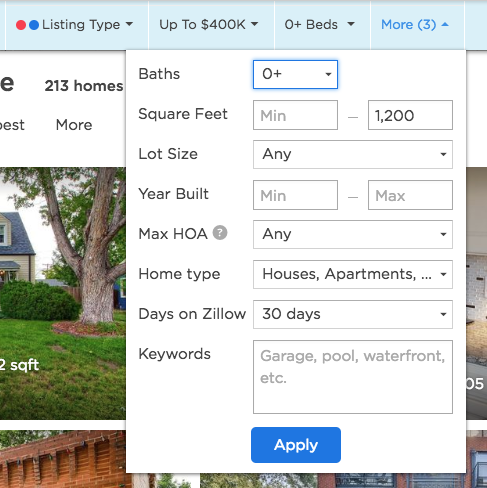
Often a rank based algorithm is provided along with knowledge based recommendations to bring the most popular items in particular categories to the user's attention.

In the next concept, you will get some practice implementing this type of recommendation for the MovieTweetings dataset.

### Recommendations with MovieTweetings: Most Popular Recommendation

Now that you have created the necessary columns we will be using throughout the rest of the lesson on creating recommendations, let's get started with the first of our recommendations.

To get started, read in the libraries and the two datasets you will be using throughout the lesson using the code below.

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tests as t

%matplotlib inline

# Read in the datasets
movies = pd.read_csv('movies_clean.csv')
reviews = pd.read_csv('reviews_clean.csv')
#del movies['Unnamed: 0']
#del reviews['Unnamed: 0']

#### 1. How To Find The Most Popular Movies

For this notebook, we have a single task.  The task is that no matter the user, we need to provide a list of the recommendations based on simply the most popular items.

For this task, we will consider what is "most popular" based on the following criteria:

* A movie with the highest average rating is considered best
* With ties, movies that have more ratings are better
* A movie must have a minimum of 5 ratings to be considered among the best movies
* If movies are tied in their average rating and number of ratings, the ranking is determined by the movie that is the most recent rating

With these criteria, the goal for this notebook is to take a **user_id** and provide back the **n_top** recommendations.  Use the function below as the scaffolding that will be used for all the future recommendations as well.

In [134]:
def get_recom_df(movies,reviews):
    # A movie with the highest average rating is considered best
    df= reviews.groupby('movie_id').count().reset_index()[['movie_id','user_id']]
    df.columns = ['movie_id', 'count']
    
    # With ties, movies that have more ratings are better
    df['ave_rating'] = reviews.groupby('movie_id').mean().reset_index()['rating']
    
    # If movies are tied in their average rating and number of ratings, the ranking is determined by the movie that is the most recent rating
    df['newest_data'] = reviews.groupby('movie_id').max().reset_index()['date']
    
    # add movie names
    df = df.merge(movies[['movie_id','movie']],how = 'inner', on='movie_id'  )
    
    # A movie must have a minimum of 5 ratings to be considered among the best movies
    df = df[df['count'] >= 5]
    
    # sort the rowes
    df = df.sort_values(by = ['ave_rating','count','newest_data'],ascending = False)   

    return df

recomm = get_recom_df(movies,reviews)

def popular_recommendations(user_id, n_top):
    '''
    INPUT:
    user_id - the user_id of the individual you are making recommendations for
    n_top - an integer of the number recommendations you want back
    OUTPUT:
    top_movies - a list of the n_top recommended movies by movie title in order best to worst
    '''    
    top_movies = list(recomm['movie'][:n_top].values)
    
    return top_movies # a list of the n_top movies as recommended

In [135]:
# Put your solutions for each of the cases here

# Top 20 movies recommended for id 1
recs_20_for_1 = popular_recommendations('1', 20)# Your solution list here

# Top 5 movies recommended for id 53968
recs_5_for_53968 = popular_recommendations('53968', 5)# Your solution list here

# Top 100 movies recommended for id 70000
recs_100_for_70000 = popular_recommendations('70000', 100)# Your solution list here

# Top 35 movies recommended for id 43
recs_35_for_43 = popular_recommendations('43', 35)# Your solution list here


**Notice:** This wasn't the only way we could have determined the "top rated" movies.  You can imagine that in keeping track of trending news or trending social events, you would likely want to create a time window from the current time, and then pull the articles in the most recent time frame.  There are always going to be some subjective decisions to be made.  

If you find that no one is paying any attention to your most popular recommendations, then it might be time to find a new way to recommend, which is what the next parts of the lesson should prepare us to do!


### Part II: Adding Filters

Now that you have created a function to give back the **n_top** movies, let's make it a bit more robust.  Add arguments that will act as filters for the movie **year** and **genre**.  

Use the cells below to adjust your existing function to allow for **year** and **genre** arguments as **lists** of **strings**.  Then your ending results are filtered to only movies within the lists of provided years and genres (as `or` conditions).  If no list is provided, there should be no filter applied.

You can adjust other necessary inputs as necessary to retrieve the final results you are looking for!

Try writing a few tests against the test function in our test function.  Below returns the top 20 movies for user 1 based on the specified year and genre filters.  Does yours return the same? 

```
t.popular_recs_filtered('1', 20, ranked_movies, years=['2015', '2016', '2017', '2018'], genres=['History'])
```

In [136]:
def get_recom_df(movies,reviews):
    # A movie with the highest average rating is considered best
    df= reviews.groupby('movie_id').count().reset_index()[['movie_id','user_id']]
    df.columns = ['movie_id', 'count']
    
    # With ties, movies that have more ratings are better
    df['ave_rating'] = reviews.groupby('movie_id').mean().reset_index()['rating']
    
    # If movies are tied in their average rating and number of ratings, the ranking is determined by the movie that is the most recent rating
    df['newest_data'] = reviews.groupby('movie_id').max().reset_index()['date']
    
    # add movie names
    df = df.merge(movies,how = 'inner', on='movie_id'  )
    
    # A movie must have a minimum of 5 ratings to be considered among the best movies
    df = df[df['count'] >= 5]
    
    # sort the rowes
    df = df.sort_values(by = ['ave_rating','count','newest_data'],ascending = False)   

    return df

recomm = get_recom_df(movies,reviews)


In [137]:
recomm.head()

,movie_id,count,ave_rating,newest_data,movie,genre,date,1800's,1900's,2000's,...,Horror,Western,Comedy,Musical,Animation,Biography,News,Sci-Fi,Fantasy,Adventure
30289,4921860,48,10.0,2016-08-15 03:16:50,MSG 2 the Messenger (2015),Comedy|Drama|Fantasy|Horror,2015,0,0,1,...,1,0,1,0,0,0,0,0,1,0
30951,5262972,28,10.0,2016-01-08 11:44:43,Avengers: Age of Ultron Parody (2015),Short|Comedy,2015,0,0,1,...,0,0,1,0,0,0,0,0,0,0
32966,6662050,22,10.0,2019-04-21 08:29:19,Five Minutes (2017),Short|Comedy,2017,0,0,1,...,0,0,1,0,0,0,0,0,0,0
25126,2737018,10,10.0,2015-05-11 08:56:01,Selam (2013),Drama|Romance,2013,0,0,1,...,0,0,0,0,0,0,0,0,0,0
31784,5804314,7,10.0,2019-12-26 03:27:47,Let There Be Light (2017),Drama,2017,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [141]:
def popular_recommendations(user_id, n_top, movie_df, years_list, genres_list):
    '''
    INPUT:
    user_id - the user_id of the individual you are making recommendations for
    n_top - an integer of the number recommendations you want back
    OUTPUT:
    top_movies - a list of the n_top recommended movies by movie title in order best to worst
    ''' 
    years_list = [int(i) for i in years_list]
    movie_df = movie_df[movie_df['date'].isin(years_list)] 
    
    movie_df = movie_df[movie_df[genres_list].sum(axis = 1) >= 1] # if any genre in the list is not zero
    
    top_movies = list(movie_df['movie'][:n_top].values)
    
    return top_movies # a list of the n_top movies as recommended


In [142]:
a = popular_recommendations('1', 20, recomm, years_list=['2015', '2016', '2017', '2018'], genres_list=['History','Fantasy'])


In [143]:
a

['MSG 2 the Messenger (2015)',
 "Hillary's America: The Secret History of the Democratic Party (2016)",
 'I Believe in Miracles (2015)',
 'Inner Workings (2016)',
 'Sekai kara neko ga kietanara (2016)',
 'Kimi no na wa. (2016)',
 'O.J.: Made in America (2016)',
 'Dayu haitang (2016)',
 'Ayla: The Daughter of War (2017)',
 'Coco (2017)',
 'They Shall Not Grow Old (2018)',
 'Hacksaw Ridge (2016)',
 'Namhansanseong (2017)',
 'The Farthest (2017)',
 'Boku no hîrô akademia THE MOVIE ~ 2-ri no eiyû ~ (2018)',
 'Inside Out (2015)',
 'Kono sekai no katasumi ni (2016)',
 'Sado (2015)',
 'Silicon Cowboys (2016)',
 '13th (2016)']